In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2022-04-03 03:59:32--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  20.7MB/s    in 12s     

2022-04-03 03:59:44 (15.0 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2022-04-03 03:59:44--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  21.0MB/s    in 2.9s    

2022-04-03 03:59:47 (21.0 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2022-04-03 03:59:47--
Total wall clock time: 15s
Downloaded: 2 files, 235M in

In [3]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [4]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [5]:
torch.cuda.is_available()

True

In [6]:
device

device(type='cuda', index=0)

In [7]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

In [8]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [9]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [10]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [11]:
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct_samples = 0
    total_samples = 0
    
    for (x, y) in loader:
        x_gpu, y_gpu = x.to(device), y.to(device)
        prediction = model(x_gpu)
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
        
    accuracy = float(correct_samples) / total_samples
    
    return accuracy


In [19]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [20]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.759883, Train accuracy: 0.768351, Val accuracy: 0.768889
Average loss: 0.615252, Train accuracy: 0.814814, Val accuracy: 0.811617
Average loss: 0.560076, Train accuracy: 0.832116, Val accuracy: 0.831479
Average loss: 0.523159, Train accuracy: 0.844965, Val accuracy: 0.823766
Average loss: 0.496309, Train accuracy: 0.852472, Val accuracy: 0.855095


In [22]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size,
                                               sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


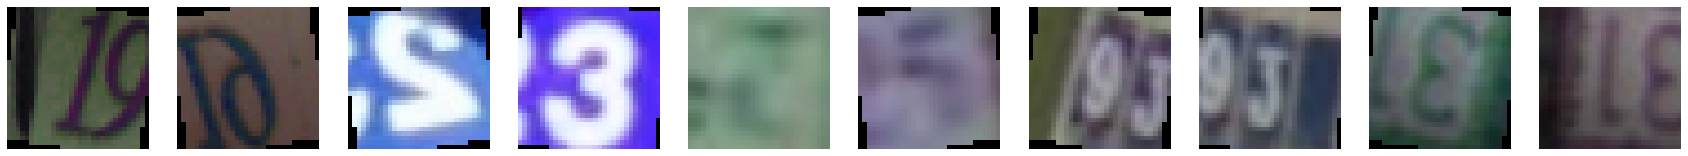

In [23]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', transform=tfs)

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


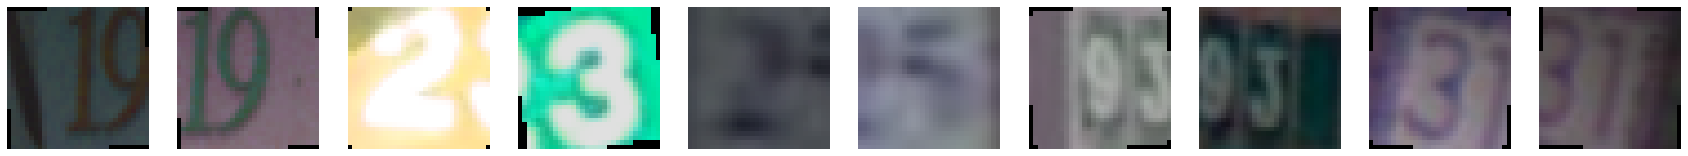

In [24]:
# TODO: Add good augmentations
tfs_for_vis = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50, brightness=0.50, contrast=0.50),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

train_aug_vis = dset.SVHN('./', transform=tfs_for_vis)

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(train_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

In [25]:
tfs_for_train = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50, brightness=0.50, contrast=0.50),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
train_aug_data = dset.SVHN('./', transform=tfs_for_train)
train_aug_loader = torch.utils.data.DataLoader(train_aug_data, batch_size=batch_size, 
                                               sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [26]:
# Finally, let's train with augmentations!
# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.715701, Train accuracy: 0.782599, Val accuracy: 0.801310
Average loss: 0.658235, Train accuracy: 0.800532, Val accuracy: 0.831479
Average loss: 0.632137, Train accuracy: 0.811384, Val accuracy: 0.842195
Average loss: 0.612155, Train accuracy: 0.817288, Val accuracy: 0.854003
Average loss: 0.597643, Train accuracy: 0.821230, Val accuracy: 0.851819


**LeNet**

In [27]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
                nn.Conv2d(3, 6, 5),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(6, 16, 5),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),    
                Flattener(),
                nn.Linear(400, 120),
                nn.ReLU(inplace=True),
                nn.Linear(120, 84),
                nn.ReLU(inplace=True),
                nn.Linear(84, 10),
                nn.LogSoftmax(dim=-1)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [28]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.308379, Train accuracy: 0.569344, Val accuracy: 0.820558
Average loss: 0.598305, Train accuracy: 0.820650, Val accuracy: 0.856256
Average loss: 0.505534, Train accuracy: 0.849350, Val accuracy: 0.876254
Average loss: 0.450678, Train accuracy: 0.864007, Val accuracy: 0.868268
Average loss: 0.422769, Train accuracy: 0.872778, Val accuracy: 0.884650
Average loss: 0.399801, Train accuracy: 0.881736, Val accuracy: 0.890792
Average loss: 0.376167, Train accuracy: 0.887315, Val accuracy: 0.889427
Average loss: 0.367578, Train accuracy: 0.890404, Val accuracy: 0.891543
Average loss: 0.354701, Train accuracy: 0.893629, Val accuracy: 0.894751
Average loss: 0.344752, Train accuracy: 0.897041, Val accuracy: 0.892294


Подбор Гиперпараметров

In [29]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-3, 1e-4] #,1e-2
regularizers = [1e-3, 1e-4, 1e-7] #, 1e-5

batch_size = 64
epoch_num = 5

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# TODO: Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!
i = 0
for lr in learning_rates:
    for reg in regularizers:
        i += 1
        print('Cycle: {0} | LR: {1} | REG: {2}'.format(i, lr, reg))

        lenet_model = nn.Sequential(
                        nn.Conv2d(3, 6, 5),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2),
                        nn.Conv2d(6, 16, 5),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2),    
                        Flattener(),
                        nn.Linear(400, 120),
                        nn.ReLU(inplace=True),
                        nn.Linear(120, 84),
                        nn.ReLU(inplace=True),
                        nn.Linear(84, 10),
                        nn.LogSoftmax(dim=-1)
                  )

        lenet_model.type(torch.cuda.FloatTensor)
        lenet_model.to(device)

        loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
        optimizer = optim.SGD(lenet_model.parameters(), lr=lr, weight_decay=reg)

        loss_history, train_history, val_history = train_model(lenet_model,
                                                               train_aug_loader, val_loader,
                                                               loss, optimizer, epoch_num)

        hp = Hyperparams(lr, reg)
        rr = RunResult(lenet_model, loss_history, val_history, val_history[-1])
        run_record[hp] = rr

Cycle: 1 | LR: 1.0 | REG: 0.001
Average loss: 2.238943, Train accuracy: 0.190765, Val accuracy: 0.186881
Average loss: 2.242504, Train accuracy: 0.189435, Val accuracy: 0.186881
Average loss: 2.242240, Train accuracy: 0.188633, Val accuracy: 0.186881
Average loss: 2.242546, Train accuracy: 0.188940, Val accuracy: 0.186881
Average loss: 2.242509, Train accuracy: 0.188991, Val accuracy: 0.186881
Cycle: 2 | LR: 1.0 | REG: 0.0001
Average loss: 2.241173, Train accuracy: 0.190953, Val accuracy: 0.186950
Average loss: 2.238297, Train accuracy: 0.191994, Val accuracy: 0.186881
Average loss: 2.242128, Train accuracy: 0.189025, Val accuracy: 0.186881
Average loss: 2.242432, Train accuracy: 0.188974, Val accuracy: 0.186881
Average loss: 2.242950, Train accuracy: 0.189690, Val accuracy: 0.186881
Cycle: 3 | LR: 1.0 | REG: 1e-07
Average loss: nan, Train accuracy: 0.093165, Val accuracy: 0.065183
Average loss: nan, Train accuracy: 0.068133, Val accuracy: 0.065183
Average loss: nan, Train accuracy: 0.

In [30]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Best validation accuracy: 0.89, best hyperparams: Hyperparams(learning_rate=0.1, reg=1e-07)


Свободное упражнение

In [31]:
# TODO: Overtake LeNet!
in_channels = 3
conv1_channels = 18
conv2_channels = 24
kernel_size = 5
linear1_size = 24*5*5
linear2_size = 200
num_output_classes = 10

cnn_model = nn.Sequential(
                nn.Conv2d(in_channels, conv1_channels, kernel_size),
                nn.BatchNorm2d(conv1_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(conv1_channels, conv2_channels, kernel_size),
                nn.BatchNorm2d(conv2_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                Flattener(),
                nn.Linear(linear1_size, linear2_size),
                nn.BatchNorm1d(linear2_size),
                nn.ReLU(inplace=True),
                nn.Linear(linear2_size, num_output_classes)
          )

cnn_model.type(torch.cuda.FloatTensor)
cnn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
#optimizer = optim.Adam(cnn_model.parameters(), lr=1e-2, weight_decay=1e-3, amsgrad=True)
optimizer = optim.SGD(cnn_model.parameters(), lr=1e-2, weight_decay=1e-3)

In [32]:
loss_history, train_history, val_history = train_model(cnn_model, train_aug_loader, val_loader, loss, optimizer, 15)

Average loss: 1.226262, Train accuracy: 0.626113, Val accuracy: 0.811071
Average loss: 0.665480, Train accuracy: 0.803467, Val accuracy: 0.840489
Average loss: 0.573579, Train accuracy: 0.827356, Val accuracy: 0.872910
Average loss: 0.531025, Train accuracy: 0.839777, Val accuracy: 0.878507
Average loss: 0.492127, Train accuracy: 0.853257, Val accuracy: 0.880759
Average loss: 0.466376, Train accuracy: 0.860048, Val accuracy: 0.887380
Average loss: 0.444792, Train accuracy: 0.866174, Val accuracy: 0.890315
Average loss: 0.424965, Train accuracy: 0.872863, Val accuracy: 0.898710
Average loss: 0.414509, Train accuracy: 0.876480, Val accuracy: 0.897550
Average loss: 0.398288, Train accuracy: 0.881992, Val accuracy: 0.904512
Average loss: 0.383874, Train accuracy: 0.886121, Val accuracy: 0.905740
Average loss: 0.376558, Train accuracy: 0.887861, Val accuracy: 0.905399
Average loss: 0.364131, Train accuracy: 0.892400, Val accuracy: 0.906832
Average loss: 0.355863, Train accuracy: 0.895591, V

In [33]:
# and 5 epochs more
loss_history, train_history, val_history = train_model(cnn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.341647, Train accuracy: 0.899652, Val accuracy: 0.902259
Average loss: 0.331269, Train accuracy: 0.902024, Val accuracy: 0.910040
Average loss: 0.328562, Train accuracy: 0.902774, Val accuracy: 0.916661
Average loss: 0.319583, Train accuracy: 0.905300, Val accuracy: 0.910859
Average loss: 0.313146, Train accuracy: 0.907484, Val accuracy: 0.916456


In [34]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(cnn_model, test_loader)
print("Final test accuracy -", final_test_accuracy)

Final test accuracy - 0.9109941610325752
